## Imports

In [1]:
!pip install pyccel

     |████████████████████████████████| 276kB 5.7MB/s 
     |████████████████████████████████| 81kB 4.9MB/s 
     |████████████████████████████████| 61kB 3.8MB/s 


In [2]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [3]:
def solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c):
   
    row, col = u.shape

    for n in range(nt + 1): 
      for j in range(row):
        for i in range(col):
          un[j][i] = u[j][i] 
        
      for j in range(1, row):
        for i in range(1, col):
          u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -(c * dt / dy * (un[j, i] - un[j - 1, i]))) 
          u[0, :] = 1
          u[-1, :] = 1
          u[:, 0] = 1
          u[:, -1] = 1 
               
    return 0

## Numba accelerator

In [7]:
@njit(fastmath=True)
def solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c):
   
    row, col = u.shape

    for n in range(nt + 1): 
      for j in range(row):
        for i in range(col):
          un[j][i] = u[j][i] 
        
      for j in range(1, row):
        for i in range(1, col):
          u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -(c * dt / dy * (un[j, i] - un[j - 1, i]))) 
          u[0, :] = 1
          u[-1, :] = 1
          u[:, 0] = 1
          u[:, -1] = 1 
               
    return 0

## Pyccel accelerator

In [6]:
def solve_2d_linearconv_pyccel(u:'float[:,:]', un:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', c:'float'):
   
    row, col = u.shape

    for n in range(nt + 1): 
      for j in range(row):
        for i in range(col):
          un[j][i] = u[j][i] 
        
      for j in range(1, row):
        for i in range(1, col):
          u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -(c * dt / dy * (un[j, i] - un[j - 1, i]))) 
          u[0, :] = 1
          u[-1, :] = 1
          u[:, 0] = 1
          u[:, -1] = 1 
               
    return 0

## Inputs

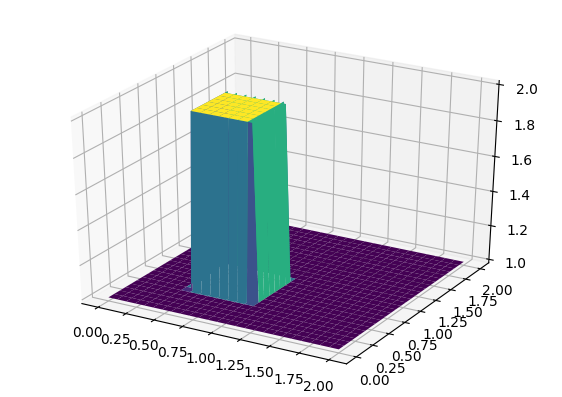

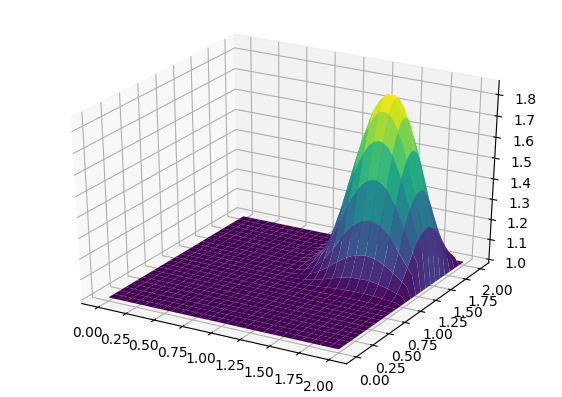

In [14]:
###variable declarations
nx = 51
ny = 51
nt = 100
c = 1.
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u0 = np.ones((ny, nx)) ##create a 1xn vector of 1's
u0[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
u = u0.copy()
un = np.ones((ny, nx)) 

solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u0[:], cmap=cm.viridis)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)

## Call Funtions

### Pure function

In [15]:
%timeit solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

1 loop, best of 5: 1.36 s per loop


### Function with numba accelerator

In [16]:
%timeit solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c)

The slowest run took 30.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 16.6 ms per loop


### Function with pyccel accelerator

In [17]:
solve_2d_linearconv_f90 = epyccel(solve_2d_linearconv_pyccel)

In [18]:
%timeit solve_2d_linearconv_f90(u, un, nt, dt, dx, dy, c)

10 loops, best of 5: 21.1 ms per loop
